# Uber Fare Analysis and Prediction

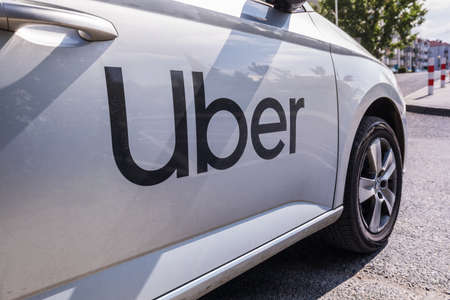

## About Dataset

### Description 
The project is about on world's largest taxi company Uber inc. In this project, I'm looking to predict the fare for their future transactional cases. Uber delivers service to lots of customers daily. Now it becomes really important to manage their data properly to come up with new business ideas to get best results. Eventually, it becomes really important to estimate the fare prices accurately.

The datset contains the following fields:
- key - a unique identifier for each trip
- fare_amount - the cost of each trip in usd
- pickup_datetime - date and time when the meter was engaged
- passenger_count - the number of passengers in the vehicle (driver entered value)
- pickup_longitude - the longitude where the meter was engaged
- pickup_latitude - the latitude where the meter was engaged
- dropoff_longitude - the longitude where the meter was disengaged
- dropoff_latitude - the latitude where the meter was disengaged

Objective:
- Understand the Dataset & cleanup (if required).
- Build Regression models to predict the fare price of uber ride.
- Also evaluate the models & compare thier respective scores like R2, RMSE, etc.

## 1️⃣ Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## 2️⃣ Data Loading and Understanding

In [3]:
# Load the dataset
df = pd.read_csv('uber.csv.zip')
df.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
# Understanding the dataset
def data_understanding(data):
    print("Shape of the dataset:", data.shape) #check the number of rows and columns of the dataset
    print("\nData Types:\n", data.dtypes) # checking the data types of each column
    print("\nMissing Values:\n", data.isnull().sum()) # checking for missing values in the dataset
    print("\nDescriptive Statistics:\n", data.describe()) # descriptive statistics of the dataset
    print("\nDuplicates:\n", data.duplicated().sum()) # checking for duplicate rows in the dataset
data_understanding(df)

Shape of the dataset: (200000, 9)

Data Types:
 Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

Missing Values:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

Descriptive Statistics:
          Unnamed: 0    fare_amount  pickup_longitude  pickup_latitude  \
count  2.000000e+05  200000.000000     200000.000000    200000.000000   
mean   2.771250e+07      11.359955        -72.527638        39.935885   
std    1.601382e+07       9.901776         11.437787         7.720539   
min    1.000000e+00     -52.000000      -1340.648410       -74.015515   
25%    1.382535e+07       6.000000        -73.99

## 3️⃣ Data Cleaning and Manipulation

In [5]:
# Dropping irrelevant columns from the dataset
df1 = df.copy() # Create a copy of the original dataframe for a better pipeline fluidity
df1.drop(['Unnamed: 0', 'key'], axis=1, inplace=True)

# Converting the pickup_datetime to a date/time format
df1['pickup_datetime'] = pd.to_datetime(df1['pickup_datetime'])

# Extracting the year, month, day, hour, minute, and second from the date/time column
df1['year'] = df1['pickup_datetime'].dt.year
df1['month'] = df1['pickup_datetime'].dt.month
df1['day'] = df1['pickup_datetime'].dt.day
df1['hour'] = df1['pickup_datetime'].dt.hour
df1['minute'] = df1['pickup_datetime'].dt.minute

# Datetime features
df1['day_of_week'] = df1['pickup_datetime'].dt.day_name()
df1['is_night'] = df1['hour'].apply(lambda h: int(h < 6 or h >= 20))
df1['is_day'] = df1['hour'].apply(lambda h: int(6 <= h < 20))

# Dropping the pickup_datetime column as it becomes irrelevant to the data 
df1.drop('pickup_datetime', axis=1, inplace=True)
df1.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,day_of_week,is_night,is_day
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,Thursday,0,1
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,Friday,1,0
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,Monday,1,0
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,Friday,0,1
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,Thursday,0,1


##### 📝 Note 
- The data above is good for data analysis purpose.
- To calculate distance between pick-up and drop-off using latitude and longitude, the most accurate and practical method is to use the Haversine formula. It calculates the great-circle distance between two points on the Earth's surface.


In [6]:
from haversine import haversine, Unit
def is_valid_coordinate(lat, lon):
    return -90 <= lat <= 90 and -180 <= lon <= 180

def calculate_distance(row):
    pickup_lat = row['pickup_latitude']
    pickup_lon = row['pickup_longitude']
    dropoff_lat = row['dropoff_latitude']
    dropoff_lon = row['dropoff_longitude']

    # Check for NaNs
    if pd.isnull(pickup_lat) or pd.isnull(pickup_lon) or pd.isnull(dropoff_lat) or pd.isnull(dropoff_lon):
        return None

    # Check for out-of-range values
    if not (is_valid_coordinate(pickup_lat, pickup_lon) and is_valid_coordinate(dropoff_lat, dropoff_lon)):
        return None

    return haversine((pickup_lat, pickup_lon), (dropoff_lat, dropoff_lon), unit=Unit.KILOMETERS)

df2 = df1.copy()  # Create a copy of the dataframe for distance calculation
df2['distance'] = df2.apply(calculate_distance, axis=1)

# Filtering DataFrame to only keep rows where fare_amount and distance are greater than 0
df2 = df2[(df2['fare_amount']>0) & (df2['distance']>0)]
df2.shape

(194335, 15)

In [7]:
# Saving the cleaned dataset to a new CSV file
df2.to_csv('uber_cleaned.csv', index=False)

In [8]:
df2.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,minute,day_of_week,is_night,is_day,distance
0,7.5,-73.999817,40.738354,-73.999512,40.723217,1,2015,5,7,19,52,Thursday,0,1,1.683325
1,7.7,-73.994355,40.728225,-73.994710,40.750325,1,2009,7,17,20,4,Friday,1,0,2.457593
2,12.9,-74.005043,40.740770,-73.962565,40.772647,1,2009,8,24,21,45,Monday,1,0,5.036384
3,5.3,-73.976124,40.790844,-73.965316,40.803349,3,2009,6,26,8,22,Friday,0,1,1.661686
4,16.0,-73.925023,40.744085,-73.973082,40.761247,5,2014,8,28,17,47,Thursday,0,1,4.475456


In [9]:
# Dropping the latitude and longitude columns as they are not needed anymore
df2.drop(columns=['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude'], inplace=True)
df2.head()

,fare_amount,passenger_count,year,month,day,hour,minute,day_of_week,is_night,is_day,distance
0,7.5,1,2015,5,7,19,52,Thursday,0,1,1.683325
1,7.7,1,2009,7,17,20,4,Friday,1,0,2.457593
2,12.9,1,2009,8,24,21,45,Monday,1,0,5.036384
3,5.3,3,2009,6,26,8,22,Friday,0,1,1.661686
4,16.0,5,2014,8,28,17,47,Thursday,0,1,4.475456


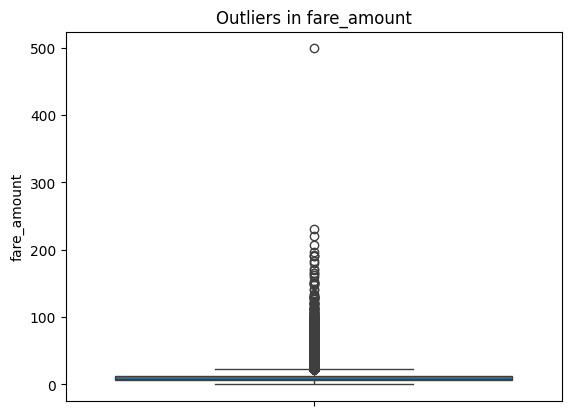

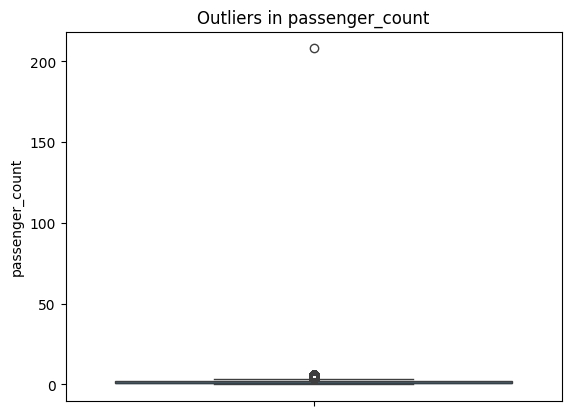

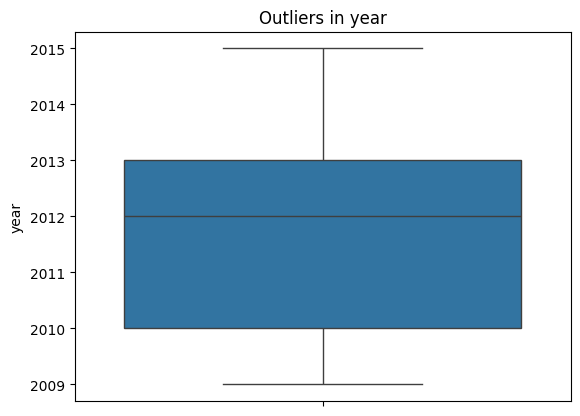

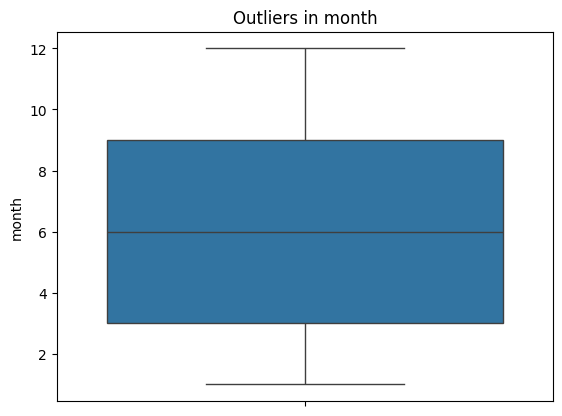

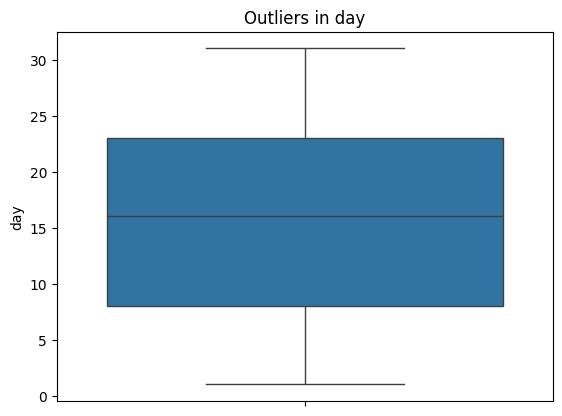

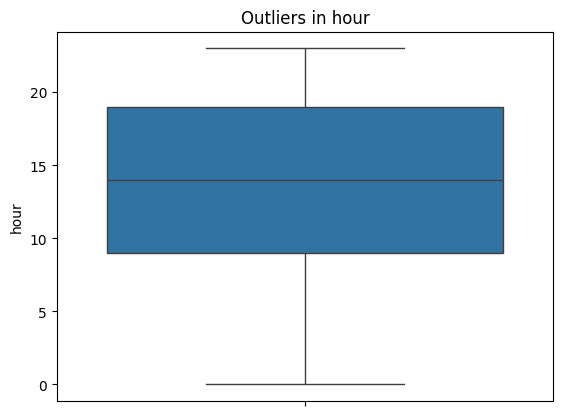

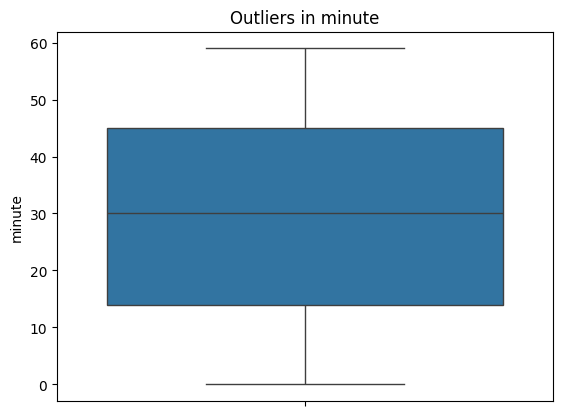

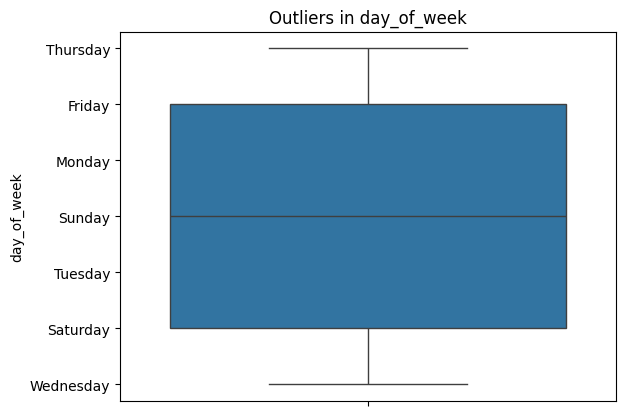

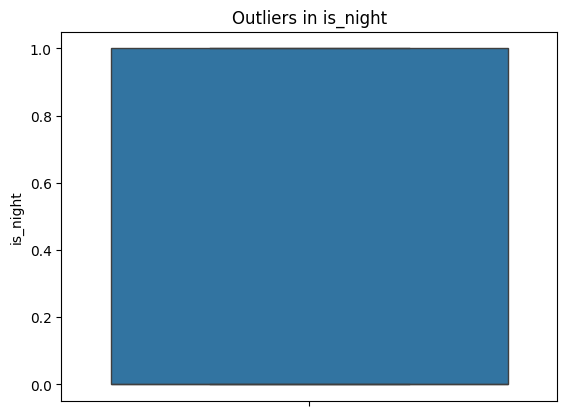

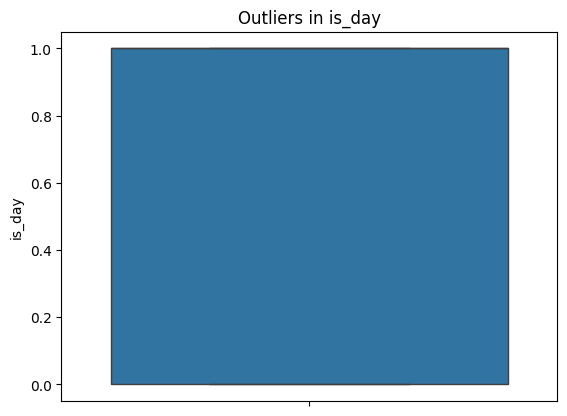

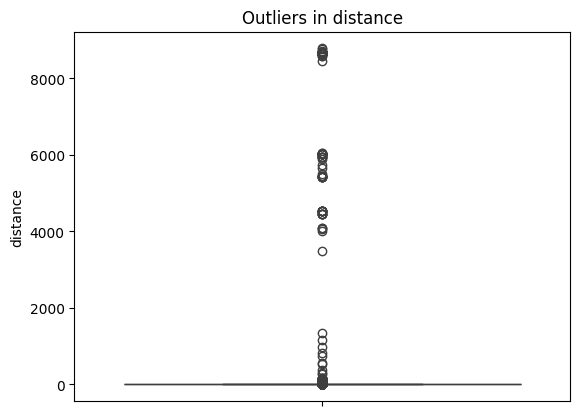

In [10]:
# Checking for outliers in all features
for column in df2.columns:
    sns.boxplot(df2[column])
    plt.title(f'Outliers in {column}')
    plt.show()


In [11]:
df2.isnull().sum()

fare_amount        0
passenger_count    0
year               0
month              0
day                0
hour               0
minute             0
day_of_week        0
is_night           0
is_day             0
distance           0
dtype: int64

<Figure size 1200x400 with 0 Axes>

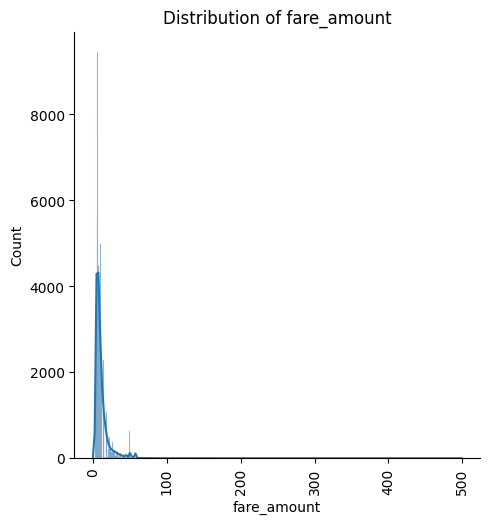

<Figure size 1200x400 with 0 Axes>

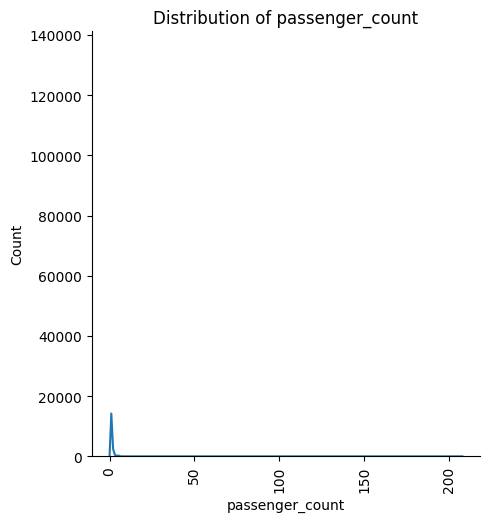

<Figure size 1200x400 with 0 Axes>

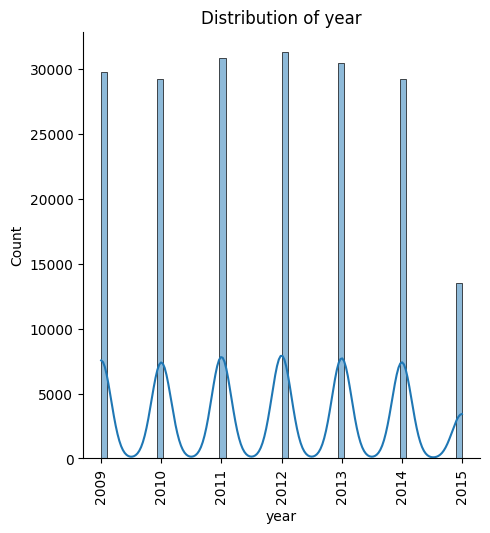

<Figure size 1200x400 with 0 Axes>

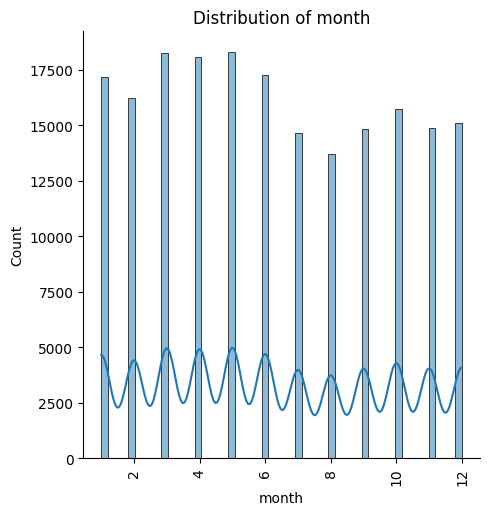

<Figure size 1200x400 with 0 Axes>

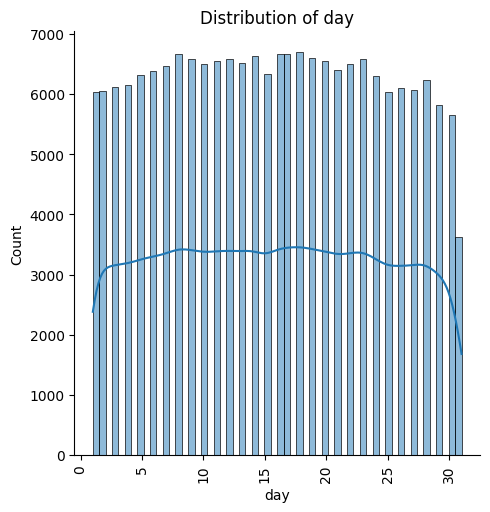

<Figure size 1200x400 with 0 Axes>

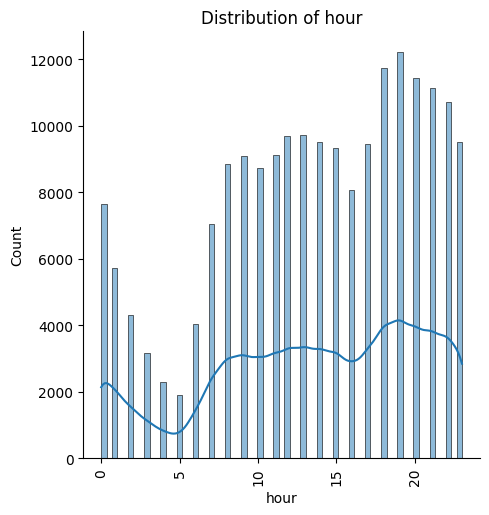

<Figure size 1200x400 with 0 Axes>

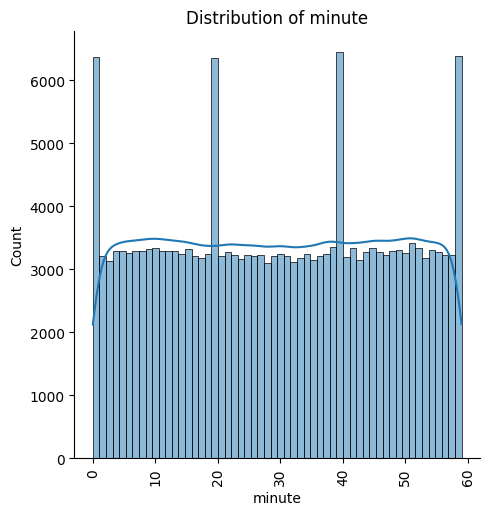

<Figure size 1200x400 with 0 Axes>

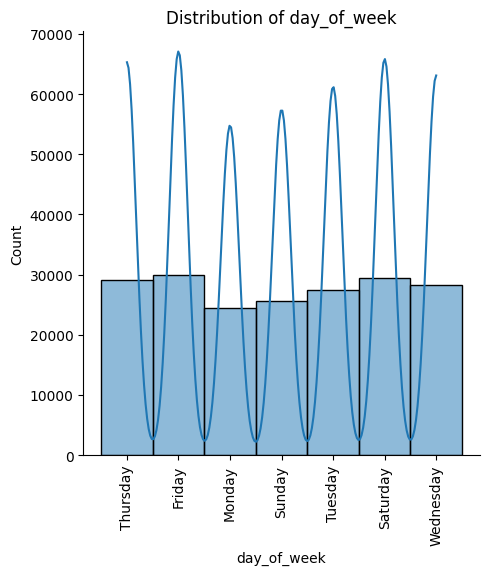

<Figure size 1200x400 with 0 Axes>

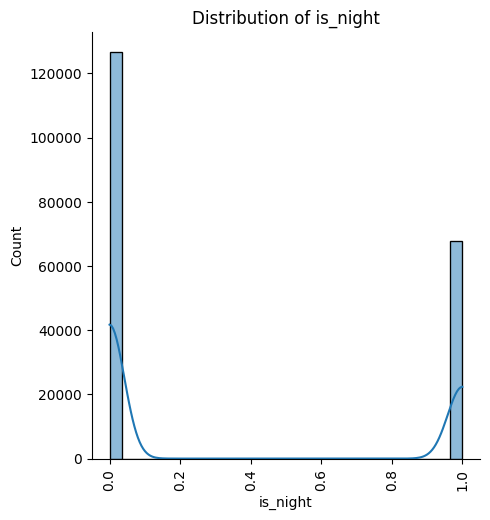

<Figure size 1200x400 with 0 Axes>

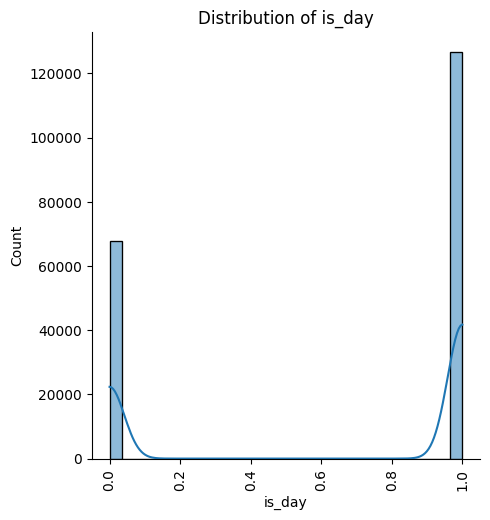

<Figure size 1200x400 with 0 Axes>

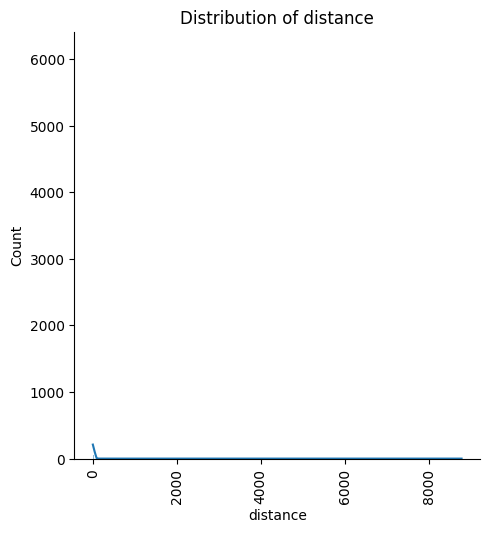

In [12]:
for column in df2.columns:
    plt.figure(figsize=(12, 4))
    sns.displot(df2[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xticks(rotation=90)
    plt.show()

In [13]:
df2['passenger_count'].value_counts()

passenger_count
1      134465
2       28620
5       13584
3        8649
6        4170
4        4156
0         690
208         1
Name: count, dtype: int64

In [14]:
# Checking for the top 10 distance values
df2[['distance']].sort_values(by='distance', ascending=False).head(10)

,distance
65591,8782.910738
34594,8776.118401
140620,8708.245092
165324,8681.117921
145538,8680.875929
78118,8680.863736
11530,8674.815939
40290,8671.717293
18887,8670.998515
115412,8670.216527


In [15]:
(df2['distance'] > 50).sum()  # Checking how many rows have distance greater than 50 km

np.int64(484)

In [16]:
# Checking the top 10 fare_amount values
df2[['fare_amount']].sort_values(by='fare_amount', ascending=False).head(10)

,fare_amount
170081,499.00
197493,230.00
29261,220.00
23682,206.38
184901,196.00
39716,191.80
114282,190.83
18415,190.00
127214,183.00
19509,180.00


In [17]:
(df2['fare_amount'] > 100).sum()

np.int64(71)

In [18]:
# Displaying the complete data of rows with fare_amount greater than 100
df2[df2['fare_amount'] > 100].head(70)

,fare_amount,passenger_count,year,month,day,hour,minute,day_of_week,is_night,is_day,distance
2053,113.66,1,2014,11,1,8,42,Saturday,0,1,0.127635
5968,105.00,1,2011,5,6,0,40,Friday,1,0,0.000420
9060,126.10,1,2011,6,13,15,46,Monday,0,1,48.706397
11301,113.00,2,2013,12,6,2,17,Friday,1,0,0.000169
15362,120.30,2,2011,6,2,15,17,Thursday,0,1,0.559509
...,...,...,...,...,...,...,...,...,...,...,...
184901,196.00,1,2009,9,17,9,38,Thursday,0,1,0.001259
188234,165.00,1,2012,8,17,12,36,Friday,0,1,0.000682
190767,120.30,3,2012,9,3,0,21,Monday,1,0,35.825742
194454,130.25,1,2013,11,22,13,7,Friday,0,1,18.100153


#### 📝 Note
 - Some of these values are not logical, such as fare_amount of over $100 for short distances, these could be due to GPS errors or data entry mistakes.
 - Therefore, we will drop these rows before applying log transformation.
 - From the above graphs it can be observed that continuous values like `fare_amount`, and `distance` are heavily skewed to the right. Therefore, we need to apply log-transformation to convert them into normal distribution. However, rows with unusually high `distance` values (e.g., over 50 km) will be dropped before applying log transformation to ensure data quality. These extreme values are likely due to GPS errors or data entry issues and would distort the transformation if left in.


- Also it can also be observed that `passenger_count` has an anomaly, with a maximum value of 208 which is quite impossible, and 609 entries with a value of 0, which is logically inconsistent. Therefore this will need to be cleaned up as well. 

In [19]:
# Dropping rows with fare_amount greater than 100 and distance less than 0.1km
df2 = df2[~((df2['fare_amount'] > 100) & (df2['distance'] < 0.1))]

df2 = df2[~df2['passenger_count'].isin([0, 208])]  # Removing rows with unrealistic passenger counts

# Removing rows with distance greater than 50 km and less than 0.1km
df2 = df2[((df2['distance'] <= 50) & (df2['distance'] >= 0.1))]  

# Creating some interaction features like fare_per_km and fare_per_passenger
df2['fare_per_km'] = df2['fare_amount'] / (df2['distance'] + 1e-3)  # Avoid division by zero
df2['fare_per_passenger'] = df2['fare_amount'] / (df2['passenger_count'] + 1e-3)

# Applying log transformation to the columns with continuous variables to reduce skewness
df2['fare_amount'] = np.log1p(df2['fare_amount'])
df2['distance'] = np.log1p(df2['distance'])
df2['fare_per_km'] = np.log1p(df2['fare_per_km'])
df2['fare_per_passenger'] = np.log1p(df2['fare_per_passenger'])

day_dummies = pd.get_dummies(df2['day_of_week'], prefix='day').astype(int)
df2 = pd.concat([df2, day_dummies], axis=1)

#### 📝 Note
I didn't apply log transformation on the passenger count column because it isn't a continuous variable like the fare_amount and distance columns. It has a specific and realistic range which is 1-6, and a log transformation won’t fix unrealistic values like 208, it will just scale them differently and still keep the bad data. Log transformation is only good for right-skewed continuous variables like fare_amount and distance.

In [20]:
# df2 is now a good candidate for further analysis as it has been cleaned, outliers removed, and new features created.
df2.to_csv('uber_cleaned_final.csv', index=False) # saving df2 to a new CSV file

# Creating a copy of df2 for modeling and dropping redundant columns
df3 = df2.copy()
df3.drop(columns=['fare_per_km', 'day_of_week', 'fare_per_passenger', 'year', 'month', 'day', 'hour', 'minute'], inplace=True)  # Dropping time-related and engineered columns

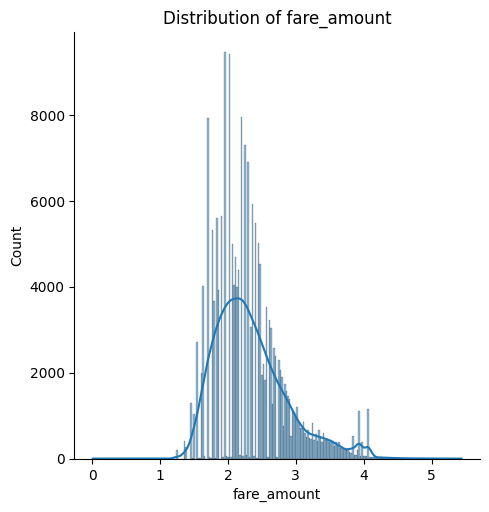

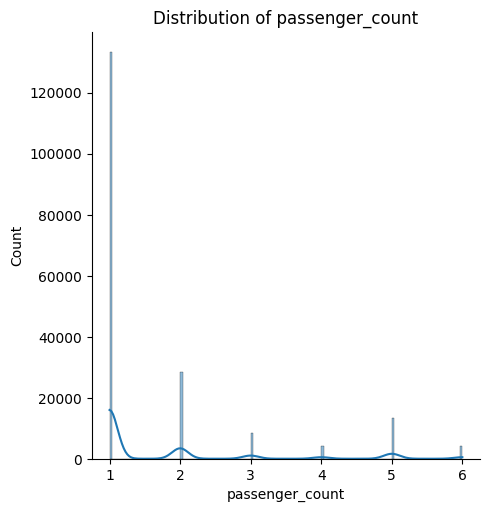

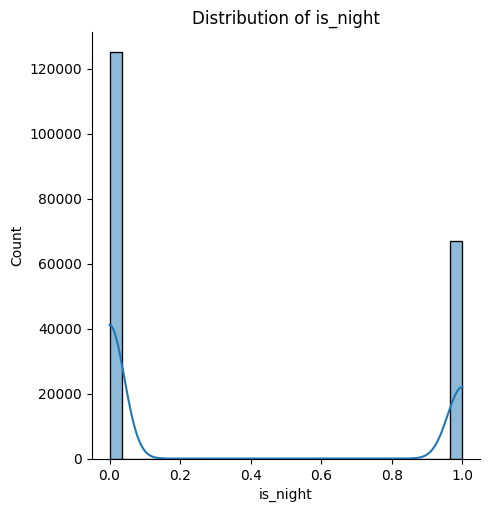

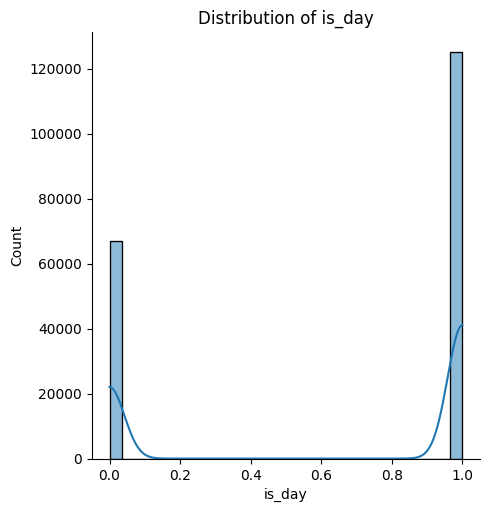

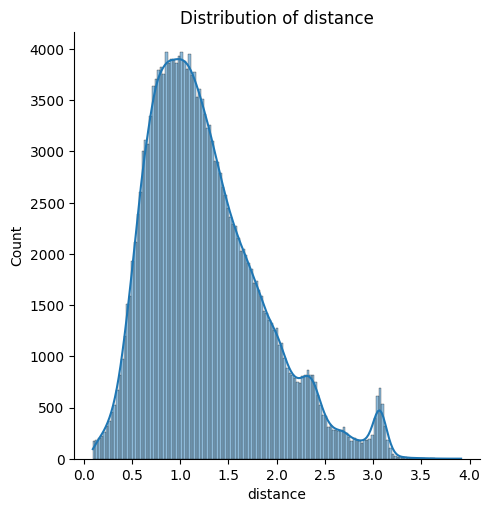

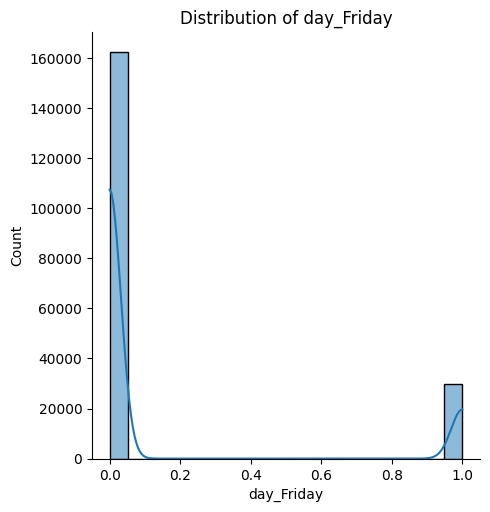

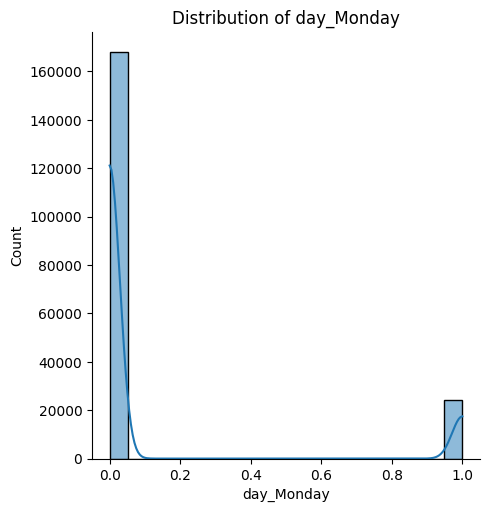

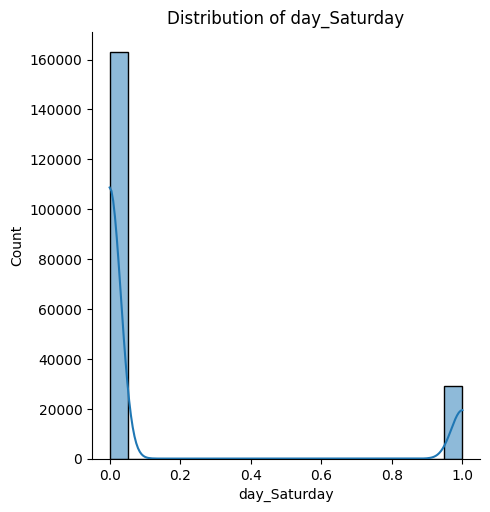

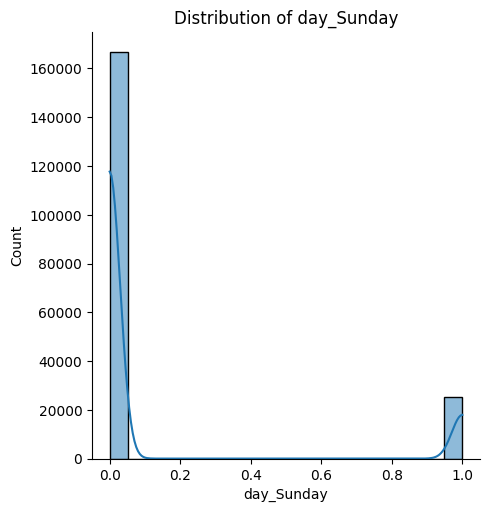

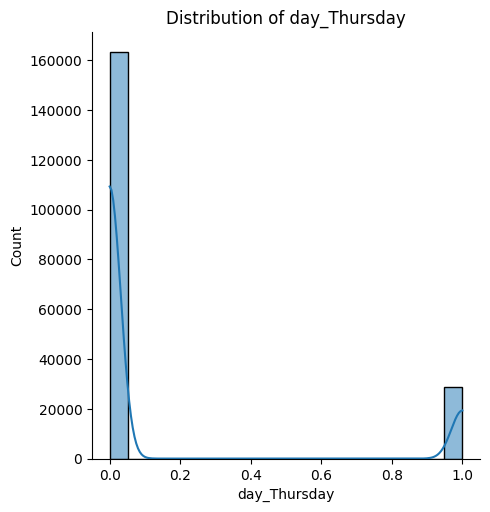

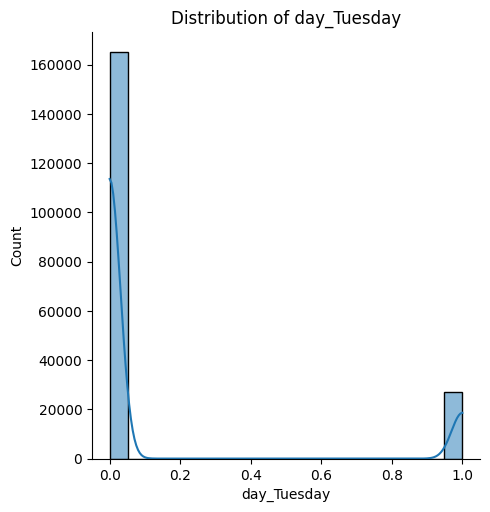

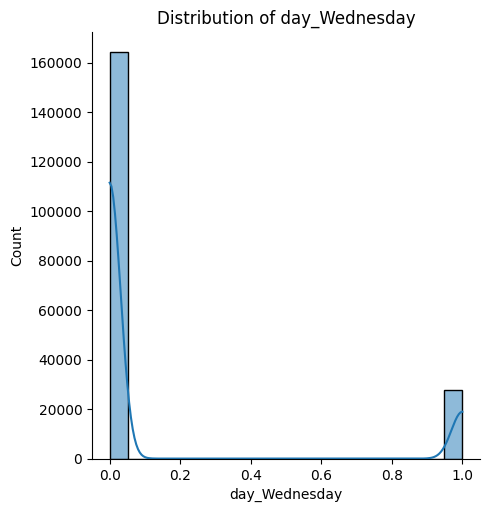

In [21]:
for column in df3.columns:
    sns.displot(df3[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.show()

In [22]:
df3.skew()

fare_amount        0.990166
passenger_count    1.979337
is_night           0.633837
is_day            -0.633837
distance           0.870424
day_Friday         1.912550
day_Monday         2.256129
day_Saturday       1.943986
day_Sunday         2.172035
day_Thursday       1.958415
day_Tuesday        2.067447
day_Wednesday      2.014048
dtype: float64

In [23]:
df3.shape  # Checking the shape of the final cleaned dataframe

(192001, 12)

In [24]:
df3.head()

,fare_amount,passenger_count,is_night,is_day,distance,day_Friday,day_Monday,day_Saturday,day_Sunday,day_Thursday,day_Tuesday,day_Wednesday
0,2.140066,1,0,1,0.987057,0,0,0,0,1,0,0
1,2.163323,1,1,0,1.240573,1,0,0,0,0,0,0
2,2.631889,1,1,0,1.797805,0,1,0,0,0,0,0
3,1.840550,3,0,1,0.978960,1,0,0,0,0,0,0
4,2.833213,5,0,1,1.700276,0,0,0,0,1,0,0


## 4️⃣ Data Preprocessing

In [25]:
# Splitting the columns into training and testing set
X = df3.drop('fare_amount', axis=1)  # Features
y = df3['fare_amount']  # Target variable

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(153600, 11)

(38401, 11)

(153600,)

(38401,)

## 5️⃣ Model Build

In [26]:
# Building an XGBoost model
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb.fit(X_train, y_train)

# Making predictions on the test set
y_pred = xgb.predict(X_test)
y_pred[:10]  # Displaying the first 10 predictions

array([2.7216997, 1.7174661, 2.2856557, 2.3842776, 1.9422868, 2.564858 ,
       2.7359254, 2.3589954, 2.9400837, 3.0278924], dtype=float32)

,Actual,Predicted
193271,2.572612,2.721700
26896,1.629241,1.717466
83574,2.163323,2.285656
193153,2.208274,2.384278
28660,1.871802,1.942287
...,...,...
169703,4.330733,3.877375
189196,1.871802,1.923516
48867,1.840550,1.999723
16934,2.674149,2.750879


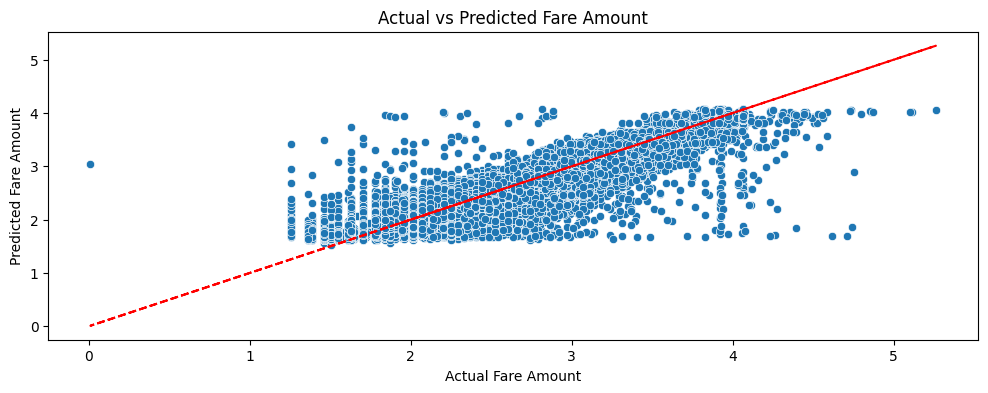

In [27]:
# Actual vs Predicted values
actpred = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(actpred)

# Displaying the comparison of actual and predicted values
plt.figure(figsize=(12,4))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot(y_test, y_test, color='red', linestyle='--')  # Adding a line for perfect predictions
plt.xlabel('Actual Fare Amount')
plt.ylabel('Predicted Fare Amount')
plt.title('Actual vs Predicted Fare Amount')
plt.show()

## 6️⃣ Model Evaluation

In [28]:
# Evaluating the model using Mean Absolute Error, Mean Squared Error, and R-squared
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

mse = mean_squared_error(y_test, y_pred)
print("MEanSquared Error:", mse)

r2 = r2_score(y_test, y_pred)
print("r2_score:", r2)

rmse = root_mean_squared_error(y_test, y_pred)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.16826557274681883
MEanSquared Error: 0.055719581790791436
r2_score: 0.807388369163599
Root Mean Squared Error: 0.23604995613384772


## 7️⃣ Hyperparameter Tuning

In [29]:
from sklearn.model_selection import GridSearchCV
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best MAE Score:", -grid_search.best_score_)

best_xgb_model = grid_search.best_estimator_

# Making predictions with the best model
y_pred_best = best_xgb_model.predict(X_test)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
Best MAE Score: 0.16818643448914988


In [30]:
# K-Fold Cross Validation
from sklearn.model_selection import KFold,cross_val_score
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

results = cross_val_score(best_xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
mae_score = -results

#MAE
print("Cross-validated MAE scores:", mae_score)
print("Mean MAE:", np.mean(mae_score))
print("Standard Deviation:", np.std(mae_score))

# MSE
mse_scores = -cross_val_score(best_xgb_model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
print("\nCross-validated MSE scores:", mse_scores)
print("Mean MSE:", np.mean(mse_scores))
print("Standard Deviation (MSE):", np.std(mse_scores))

# RMSE (square root of MSE)
rmse_scores = np.sqrt(mse_scores)
print("\nCross-validated RMSE scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Standard Deviation (RMSE):", np.std(rmse_scores))

# R2 Score
r2_scores = cross_val_score(best_xgb_model, X_train, y_train, cv=kfold, scoring='r2')
print("\nCross-validated R² scores:", r2_scores)
print("Mean R2:", np.mean(r2_scores))
print("Standard Deviation (R²):", np.std(r2_scores))

Cross-validated MAE scores: [0.16574098 0.16792475 0.16882544 0.167778   0.16791484 0.16721838
 0.17040494 0.16931325 0.16846693 0.1682906 ]
Mean MAE: 0.16818781113919096
Standard Deviation: 0.0011796498541693074

Cross-validated MSE scores: [0.05226453 0.05577526 0.05773437 0.05407452 0.055996   0.05378763
 0.05845132 0.05518219 0.05700188 0.05619134]
Mean MSE: 0.055645903752174763
Standard Deviation (MSE): 0.0017910510240994892

Cross-validated RMSE scores: [0.22861438 0.23616786 0.24027977 0.23253928 0.23663474 0.2319216
 0.24176707 0.2349089  0.23875067 0.23704713]
Mean RMSE: 0.23586313991820335
Standard Deviation (RMSE): 0.0038056510744935673

Cross-validated R² scores: [0.81644714 0.81019912 0.80331459 0.81493825 0.81031004 0.81278236
 0.80002375 0.8111405  0.80733261 0.81123324]
Mean R2: 0.8097721605283278
Standard Deviation (R²): 0.00476934996580633


## 8️⃣ Feature Importance Analysis

<Figure size 1200x400 with 0 Axes>

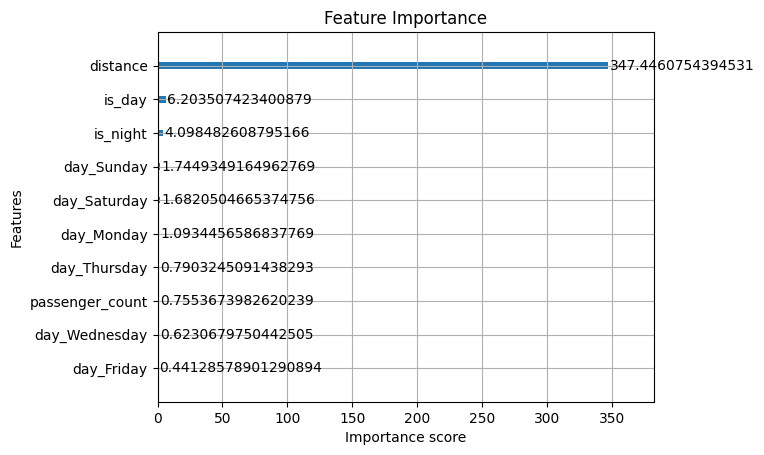

In [31]:
# Recreate a DataFrame with the features while retaining feature names
X_df = pd.DataFrame(X, columns=X.columns)

# Retraining the XGBoost model with this DataFrame
best_xgb_model.fit(X_df, y)

from xgboost import plot_importance
plt.figure(figsize=(12,4))
plot_importance(best_xgb_model, max_num_features=10, importance_type='gain')
plt.title('Feature Importance')
plt.show()

## 9️⃣ Residual Analysis

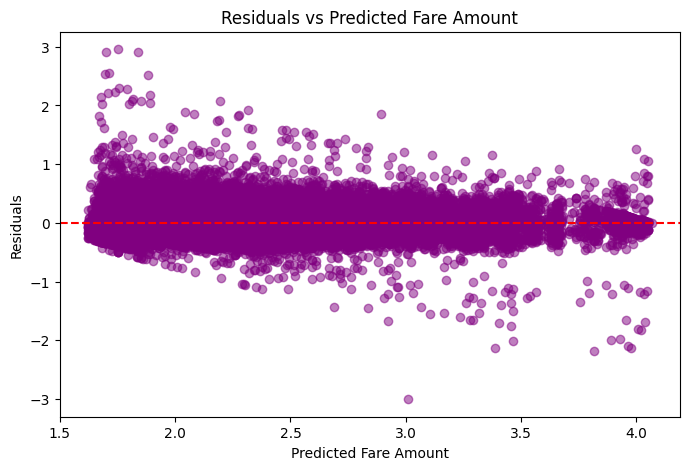

In [32]:
# Predict on test set
y_pred = best_xgb_model.predict(X_test)

# Calculate residuals
residuals = y_test - y_pred

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Fare Amount')
plt.xlabel('Predicted Fare Amount')
plt.ylabel('Residuals')
plt.show()

## 🔟 Saving and Exporting the Model

In [33]:
import joblib

# Save model using joblib
joblib.dump(best_xgb_model, 'xgb_fare_model.pkl')

# Save model in native XGBoost format
best_xgb_model.save_model('xgb_fare_model.json')

## Explainability (SHAP values)

100%|===================| 38305/38401 [02:33<00:00]        

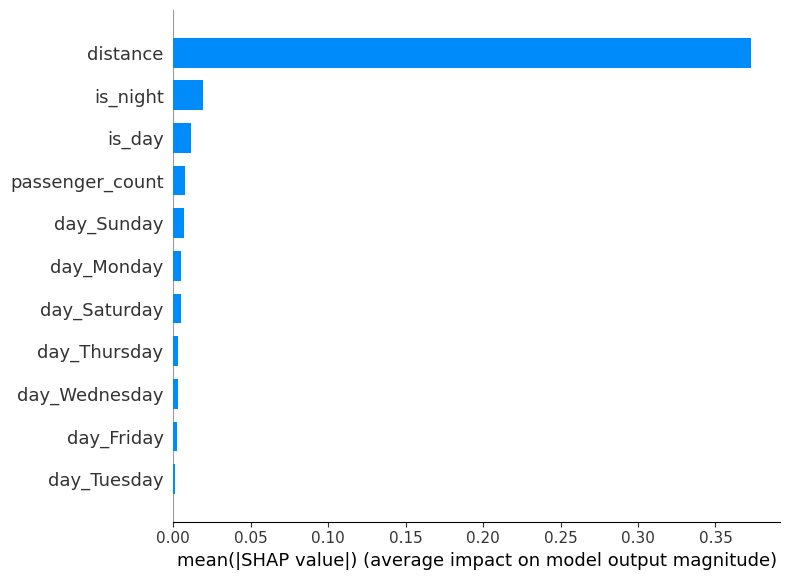

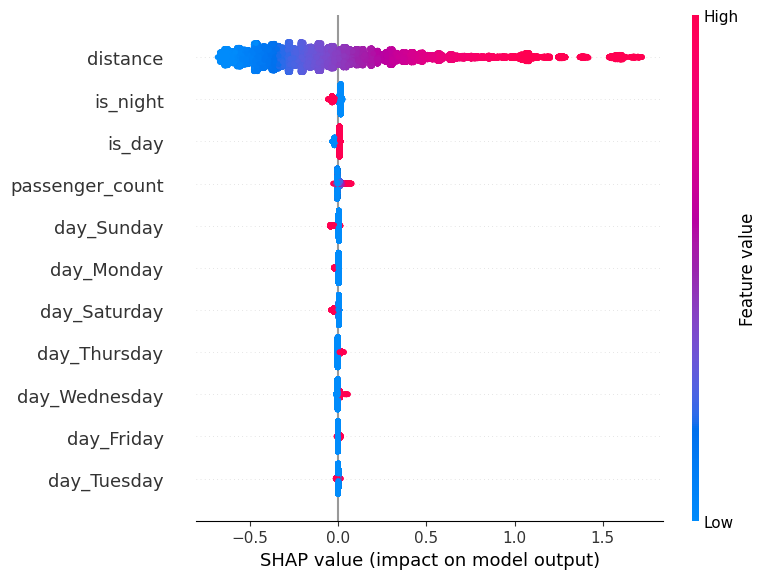

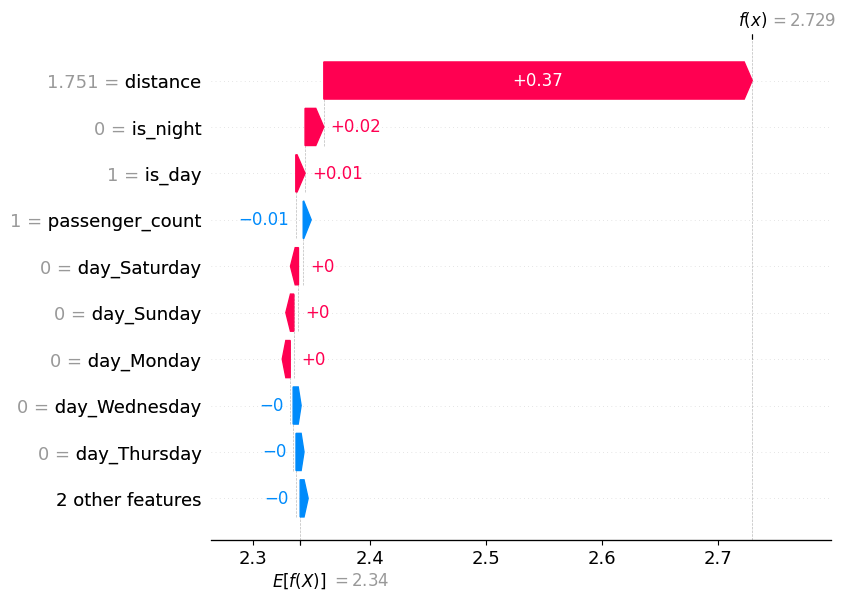

In [34]:
import shap

# Recreate a DataFrame with the test features while retaining feature names
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Create an explainer
explainer = shap.Explainer(best_xgb_model, X_test_df)

# Calculate SHAP values for the test set
shap_values = explainer(X_test_df)

# Plot SHAP values
shap.summary_plot(shap_values, X_test_df, plot_type="bar") # summary plot for feature importance
shap.summary_plot(shap_values, X_test_df)  # summary plot for feature contributions

# Explain a single prediction
shap.plots.waterfall(shap_values[0])

